# Import modules

Activate the environment where the wri project is located. If there is not one, install requirements in the wrilatinamerica.txt. https://github.com/OmdenaAI/wrilatinamerica/blob/master/requirements.txt

In [1]:
# !conda activate wri_omdena

In [1]:
from src.models import segment_highlighter

from sentence_transformers import SentenceTransformer
from scipy.spatial import distance

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import gzip
import json
import string

import nltk # imports the natural language toolkit
import plotly
from wordcloud import WordCloud
import es_core_news_md

from collections import Counter
from nltk.util import ngrams
import re
import os

import boto3
import json
from PyPDF2 import PdfFileReader
from io import BytesIO

# Defining Queries

In the following lines, we use the excel file with the selected phrases of each country, process them and get N-grams to define basic queries for the SBERT model.

In [3]:
data = pd.read_excel(r'WRI_Policy_Tags (1).xlsx', sheet_name = None)
df = None

if isinstance(data, dict):
    for key, value in data.items():
        if not isinstance(df,pd.DataFrame):
            df = value
        else:
            df = df.append(value)
else:
    df = data
df.head()

,Document,Text,Incentive Instrument,Land Use Type,Category,Unique Policy #,Key words,relevant sentences,Key Words
0,2019 ACUERDO por el que se emiten los Lineamie...,Generar empleo y garantizara la población camp...,"Direct payment (PES), Credit, Technical assist...","Forest, Agriculture (Crop)",Incentive,1 (Sembrando Vida),"insumo, crédito, capacitación, asistencia técnica",NaN,NaN
1,2019 ACUERDO por el que se emiten los Lineamie...,\nEl Programa incentivará a los sujetos agrari...,"Direct payment (PES), Credit, Technical assist...","Forest, Agriculture (Crop)",Incentive,1 (Sembrando Vida),incentivar,NaN,NaN
2,2019 ACUERDO por el que se emiten los Lineamie...,Los sujetos agrarios beneficiados por el progr...,"Supplies, Technical assistance","Forest, Agriculture (Crop)",Incentive,1 (Sembrando Vida),"apoyo económico, apoyos en especie, insumos, h...",NaN,NaN
3,2019 ACUERDO por el que se emiten los Lineamie...,"El sujeto de derecho, recibirá un apoyo económ...",Direct payment (PES),"Forest, Agriculture (Crop)",Incentive,1 (Sembrando Vida),pesos,NaN,NaN
4,2019 ACUERDO por el que se emiten los Lineamie...,"El sujeto de derecho, recibirá en especie las ...",Supplies,"Forest, Agriculture (Crop)",Incentive,1 (Sembrando Vida),recibir,NaN,NaN


Text(0.5, 1.0, 'Histogram of number of words per sentence')

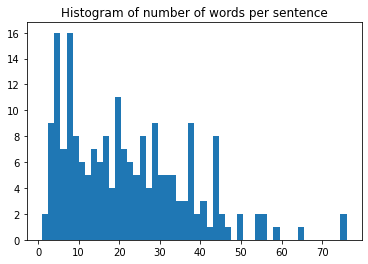

In [4]:
sentences = df["relevant sentences"].apply(lambda x: x.split(";") if isinstance(x,str) else x)
sentence = []

for elem in sentences:
    if isinstance(elem,float) or len(elem) == 0:
        continue
    elif isinstance(elem,list):
        for i in elem:
            if len(i.strip()) == 0:
                continue
            else:
                sentence.append(i.strip())
    else:
        if len(elem.strip()) == 0:
            continue
        else:
            sentence.append(elem.strip())

sentence
words_per_sentence = [len(x.split(" ")) for x in sentence]
plt.hist(words_per_sentence, bins = 50)
plt.title("Histogram of number of words per sentence")

In [5]:
def top_k_ngrams(word_tokens,n,k):
    
    ## Getting them as n-grams
    n_gram_list = list(ngrams(word_tokens, n))

    ### Getting each n-gram as a separate string
    n_gram_strings = [' '.join(each) for each in n_gram_list]
    
    n_gram_counter = Counter(n_gram_strings)
    most_common_k = n_gram_counter.most_common(k)
    print(most_common_k)

noise_words = []
stopwords_corpus = nltk.corpus.stopwords
sp_stop_words = stopwords_corpus.words('spanish')
noise_words.extend(sp_stop_words)
print(len(noise_words))

if "no" in noise_words:
    noise_words.remove("no")

tokenized_words = nltk.word_tokenize(''.join(sentence))
word_freq = Counter(tokenized_words)
# word_freq.most_common(20)
# list(ngrams(tokenized_words, 3))

word_tokens_clean = [re.findall(r"[a-zA-Z]+",each) for each in tokenized_words if each.lower() not in noise_words and len(each.lower()) > 1]
word_tokens_clean = [each[0].lower() for each in word_tokens_clean if len(each)>0]

313


## Building queries with Parts-Of-Speech

The following functions take a specific word and find the next or previous words according to the POS tags.

An example is shown below with the text: <br>

text = "Generar empleo y garantizara la población campesina el bienestar y su participación e incorporación en el desarrollo nacional, y fomentará la actividad agropecuaria y forestal para el óptimo uso de la tierra, con obras de infraestructura, insumos, créditos, servicios de capacitación y asistencia técnica" <br>

next_words(text, "empleo", 3) <br>
prev_words(text, "garantizara", 6) <br>

Will return: <br>

>['garantizara', 'población', 'campesina'] <br>
>['Generar', 'empleo']

In [ ]:
nlp = es_core_news_md.load()

def ExtractInteresting(sentence, match = ["ADJ","ADV", "NOUN", "NUM", "VERB", "AUX"]):
    words = nltk.word_tokenize(sentence)
#     interesting = [k for k,v in nltk.pos_tag(words) if v in match]
    doc = nlp(sentence)
    interesting = [k.text for k in doc if k.pos_ in match]
    return(interesting)

def next_words(sentence, word, num_words, match = ["ADJ","ADV", "NOUN", "NUM", "VERB", "AUX"]):

    items = list()
    doc = nlp(sentence)
    text = [i.text for i in doc]

    if word not in text: return ""
    
    idx = text.index(word)
    for num in range(num_words):
        
        pos_words = [k.text for k in doc[idx:] if k.pos_ in match]
        if len(pos_words) > 1: 
            items.append(pos_words[1])
            idx = text.index(pos_words[1])
    
    return items
    
def prev_words(sentence, word, num_words, match = ["ADJ","ADV", "NOUN", "NUM", "VERB", "AUX"]):
    
    items = list()
    doc = nlp(sentence)
    text = [i.text for i in doc]

    if word not in text: return ""
    
    idx = text.index(word)
    for num in range(num_words):
        pos_words = [k.text for k in doc[:idx] if k.pos_ in match]
        if len(pos_words) >= 1: 
            items.insert(0, pos_words[-1]) #Add element in order and take the last element since it is the one before the word
            idx = text.index(pos_words[-1])
    
    return items

## n-grams size
We define the size of the n-gram that we want to find. The larger it is, the less frequent it will be, unless we substantially increase the number of phrases.

In [7]:
n_grams = 3

top_k_ngrams(word_tokens_clean, n_grams, 20)

[('manejo bosques naturales', 12), ('tierras vocaci forestal', 8), ('ministerio finanzas p', 8), ('bosques naturales fines', 8), ('programa incentivos forestales', 7), ('instituto nacional bosques', 7), ('plan manejo forestal', 7), ('poseedores peque extensiones', 6), ('establecimiento mantenimiento plantaciones', 6), ('mantenimiento plantaciones forestales', 6), ('otorgar incentivos forestales', 6), ('cuyas solicitudes ingreso', 6), ('solicitudes ingreso programa', 6), ('ingreso programa aprobadas', 6), ('programa aprobadas a', 6), ('naturales fines producci', 5), ('nacional bosques inab', 5), ('seg plan manejo', 5), ('aprobadas a proyectos', 5), ('incentivos forestales poseedores', 4)]


# Accesing documents in S3

Use the json file with the key and password to access the S3 bucket if necessary. 
If not, skip this section and use files in a local folder. 

In [ ]:
path = ""
filename = "Omdena_key.json"
file = path + filename
with open(file, 'r') as dict:
    key_dict = json.load(dict)

In [ ]:
for key in key_dict:
    KEY = key
    SECRET = key_dict[key]

In [ ]:
s3 = boto3.resource(
    service_name = 's3',
    region_name = 'us-east-2',
    aws_access_key_id = KEY,
    aws_secret_access_key = SECRET
)

In [ ]:
## Get the list of objects in the bucket that are relevant
policy_list = s3.Bucket('wri-latin-policies').objects.all().filter(Prefix='full')

## This allows to loop through the files

# i = 0
# for obj in s3.Bucket('wri-latin-policies').objects.all().filter(Prefix='full'):
#     if i < 1: #Limit for testing purposes. if present the loop will go only through the first element
#         key = "Pre-processed/" + obj.key.replace("full/", '') + ".txt" 
#         file = obj.get()['Body'].read() #get the file from S3
#         pdf = PdfFileReader(BytesIO(file)) #load the file in pdf format if necessary
#         for page in range(0, pdf.getNumPages()):
#             pdf_page = pdf.getPage(page) #Retrieve the content of each page
#             pdf_content = pdf_page.extractText() #Extract only the text of each page
# #           HERE YOU SHOULD RUN YOUR PRE-PROCESSING PIPELINE AND ADD UP EVERY PAGE IN A VARIABLE called "content" as string
#         s3.Object('wri-latin-policies', key).put(Body = content)#This will save all the contents in the string variable "content" into a txt file in the Pre-processed folder
#     i += 1

# Initializing the model

First, we import the sBERT model. Several transformers are available and documentation is here: https://github.com/UKPLab/sentence-transformers <br>

The following functions are:
- Get cosine similarity between two texts
- Highlight: a function that receives the model, document, query and precision and returns all the highlights that are above that precision.

In [ ]:
# transformer_name='xlm-r-100langs-bert-base-nli-mean-tokens'
transformer_name = "distiluse-base-multilingual-cased"
model = SentenceEmbeddings(transformer_name)

def get_similarity(model, text1, text2):
    '''
    Given two texts, calculate the cosine similarity between their sentence embeddings.
    '''
    text1_embedding = model.encode(text1)
    text2_embedding = model.encode(text2)
    return 1 - distance.cosine(text1_embedding, text2_embedding)


def highlight(model, document, query, precision):

    '''document must be the json or txt document to be able to extract page'''
    highlights = []
    scores = []
    pages = []
    
## Modify this part to change the processing of the json / dict policy ---------------------------

    if isinstance(document, dict): 
        for page_num, text in document.items():
            
            ## This section is preprocessing ---------------------------------------
            page_num = page_num.split("_")[1]
            for sentence in text.split("\n\n"):
                sentence = re.sub("\n", " ", sentence)
                sentence = re.sub(" +", " ", sentence)
                sentence = sentence.strip()
                if len(sentence) < 60:
                    continue
             ## ---------------------------------------------------------------------------
             ## Next, get the scores and stores the highlights
                
                score = get_similarity(model, sentence, query)
                if score > precision:
                    highlights.append(sentence)
                    scores.append(score)
                    pages.append(page_num)
        sorted_idxs = np.argsort(scores)[::-1]
        highlights = [highlights[idx] for idx in sorted_idxs]
        scores = [scores[idx] for idx in sorted_idxs]
        pages = [pages[idx] for idx in sorted_idxs]

        return highlights, scores, pages
# -----------------------------------------------------------------------------
    else:
        preprocessor = TextPreprocessor()
        clean_text = preprocessor.clean_sentence(document)
        paragraphs = preprocessor.split_into_paragraphs(document)

        for paragraph in paragraphs:
            paragraph = re.sub("\n", " ", sentence)
            paragraph = re.sub(" +", " ", sentence)
            paragraph = paragraph.strip()
            if len(paragraph) < 60:
                continue
            score = get_similarity(model, paragraph, query)
            if score > precision:
                highlights.append(paragraph)
                scores.append(score)
        sorted_idxs = np.argsort(scores)[::-1]
        highlights = [highlights[idx] for idx in sorted_idxs]
        scores = [scores[idx] for idx in sorted_idxs]

        return highlights, scores, None

In [ ]:
# Configure module
highlighter_class = "sbert"
highlighter_id = "X"
highlighter_query = "beneficio económico"
highlighter_precision = 0.05

# Instantiate models from the Omdena files
# highlighter_class = highlighter_classes[highlighter_class]
# highlighter = highlighter_class.load(highlighter_id)

In [ ]:
policy_folder = r"_____"

In [ ]:
# for policy in policy_list:  #Uncomment and comment the next 2 lines if the files are fetched from S3 bucket.

highlight_list = []
scores_list = []
pages_list = []

for policy in os.listdir(policy_folder):
    policy = os.path.join(policy_folder, policy)
    
    if "json" in policy:
        with open(policy_path, "r", encoding="utf-8") as f:
            policy = json.load(f)
        highlights, score, pages = highlight(
            policy, highlighter_query, highlighter_precision
        )
            
    elif "txt" in policy:
        policy = open(policy_path, "r", encoding="utf-8")
        highlights, score, pages = highlight(
            policy, highlighter_query, highlighter_precision
        )
    
    highlight_list.append(highlights)
    scores_list.append(highlights)
    pages_list.append(highlights)